In [1]:
# All imports
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
from separation import get_separation
from proximity import get_proximity, calculate_closest_distance

In [5]:
# Load data
disease = pd.read_csv("../../Data/task3/disease_gene.tsv", sep="\t")
ppi = pd.read_csv("../../Data/task3/PPI.csv")
drug_df = pd.read_csv("../../Data/task3/drug_target.csv")



In [6]:
# Build interactome graph
G = nx.from_pandas_edgelist(ppi, "Symbol_A", "Symbol_B")
ppi_genes = set(G.nodes())
print(f"Interactome: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Interactome: 18508 nodes, 332645 edges


In [7]:
# Apply mandatory filters following professor's approach

# 1. Filter disease_gene associations: exclude "group" and "phenotype" types, keep only disease type
disease = disease[disease['diseaseType'] == 'disease'][['geneSymbol', 'diseaseName']].drop_duplicates()

# Lower disease names in place
disease['diseaseName'] = disease['diseaseName'].str.lower()

# Count genes per disease
num_genes = (disease.groupby('diseaseName')
             .agg('count')
             .sort_values(by='geneSymbol')
             .reset_index()
             .rename(columns={'geneSymbol':'count_genes'}))

# Merge back and filter diseases with > 10 genes
filtered_disease = disease.merge(num_genes, 
                                on='diseaseName', 
                                how='inner')

disease = filtered_disease[filtered_disease.count_genes > 10][['geneSymbol', 'diseaseName']].drop_duplicates().reset_index(drop=True)

# 2. Filter drug targets to humans only
drug_df = drug_df[drug_df['organism'] == 'Humans']

# 3. Filter drug targets with valid gene targets in PPI network
drug_df = drug_df[drug_df["Gene_Target"].notna()].copy()
drug_df["targets"] = drug_df["Gene_Target"].apply(lambda x: x.split(";"))
drug_df["targets_in_ppi"] = drug_df["targets"].apply(lambda lst: list(set(lst) & ppi_genes))
drug_df = drug_df[drug_df["targets_in_ppi"].apply(len) > 0]

print(f"Filtered disease associations: {len(disease)} rows")
print(f"Filtered drugs: {len(drug_df)} drugs")
print(f"Unique diseases: {disease['diseaseName'].nunique()}")

Filtered disease associations: 44439 rows
Filtered drugs: 22007 drugs
Unique diseases: 920


## 3.1 Disease Module Construction

In [11]:
# Get AD genes that exist in the PPI network
ad_df = disease[disease["diseaseName"] == "alzheimer's disease"]
genes_AD = set(ad_df["geneSymbol"].dropna()) & ppi_genes
print(f"AD genes total: {len(ad_df)}, in PPI: {len(genes_AD)}")

AD genes total: 101, in PPI: 91


In [12]:
# Build AD subgraph and extract LCC
H = G.subgraph(genes_AD).copy()
components = list(nx.connected_components(H))
lcc = max(components, key=len)
module = H.subgraph(lcc).copy()

print(f"Components: {len(components)}, LCC size: {len(lcc)} nodes, {module.number_of_edges()} edges")

Components: 42, LCC size: 46 nodes, 132 edges


In [13]:
# Export edges (remove self-loops)
edge_df = nx.to_pandas_edgelist(module)
edge_df = edge_df[edge_df["source"] != edge_df["target"]]
edge_df.to_csv("../../Data/task3/AD_module_edges.csv", index=False)
edge_df.to_csv("../../Data/task3/AD_module_edges.tsv", sep="\t", index=False)

print(f"Exported {len(edge_df)} edges (self-loops removed)")
edge_df.head()

Exported 87 edges (self-loops removed)


,source,target
0,CASP3,APP
1,CASP3,PSEN1
3,CASP3,BCL2
4,CASP3,PSEN2
5,CASP3,MAPT


## 3.1b Significance Test

In [14]:
# Random module comparison
def random_lcc_size(G, n):
    nodes = random.sample(list(G.nodes()), n)
    sub = G.subgraph(nodes)
    comps = list(nx.connected_components(sub))
    return len(max(comps, key=len)) if comps else 0

N = 1000
real_size = len(lcc)
random_sizes = [random_lcc_size(G, real_size) for _ in range(N)]

# Statistics
mean_rand, std_rand = np.mean(random_sizes), np.std(random_sizes, ddof=1)
z_score = (real_size - mean_rand) / std_rand
p_value = np.mean(np.array(random_sizes) >= real_size)

print(f"Random LCC: mean={mean_rand:.2f}, std={std_rand:.2f}")
print(f"Real LCC: {real_size}, Z-score: {z_score:.2f}, p-value: {p_value}")

Random LCC: mean=2.28, std=1.39
Real LCC: 46, Z-score: 31.53, p-value: 0.0


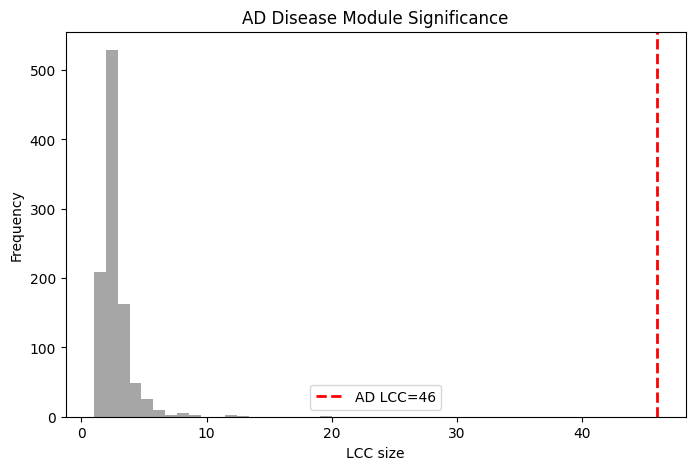

In [15]:
# Plot significance
plt.figure(figsize=(8, 5))
plt.hist(random_sizes, bins=20, alpha=0.7, color="gray")
plt.axvline(real_size, color="red", linestyle="dashed", linewidth=2, label=f"AD LCC={real_size}")
plt.xlabel("LCC size")
plt.ylabel("Frequency")
plt.title("AD Disease Module Significance")
plt.legend()
plt.savefig("../../images/LCC_size.png", dpi=150, bbox_inches="tight")
plt.show()

## 3.2 Disease Separation Analysis

Following the approach from `separation.py`, we compute the network separation $s_{AB}$ between disease modules:

$$s_{AB} = \langle d_{AB} \rangle - \frac{\langle d_{AA} \rangle + \langle d_{BB} \rangle}{2}$$

Where distances use the **mean of minimum shortest paths** for each gene to the other set.

In [16]:
# Get all diseases with their gene counts
disease_genes_map = {}
for name, group in disease.groupby("diseaseName"):
    genes = set(group["geneSymbol"].dropna()) & ppi_genes
    if len(genes) >= 10:  # Only consider diseases with at least 10 genes in PPI
        overlap = len(genes & genes_AD)
        disease_genes_map[name] = {
            "genes": genes, 
            "count": len(genes), 
            "overlap": overlap,
            "overlap_pct": overlap / len(genes_AD) * 100
        }

# Sort by overlap percentage
sorted_diseases = sorted(disease_genes_map.items(), key=lambda x: x[1]["overlap_pct"], reverse=True)

print("Diseases with highest overlap with AD:")
for name, info in sorted_diseases[:10]:
    print(f"  {name}: {info['count']} genes, {info['overlap']} overlap ({info['overlap_pct']:.1f}%)")

print("\nDiseases with lowest overlap with AD:")
for name, info in sorted_diseases[-1200:-1180]:
    print(f"  {name}: {info['count']} genes, {info['overlap']} overlap ({info['overlap_pct']:.1f}%)")

Diseases with highest overlap with AD:
  alzheimer's disease: 91 genes, 91 overlap (100.0%)
  familial alzheimer disease (fad): 90 genes, 90 overlap (98.9%)
  acute confusional senile dementia: 89 genes, 89 overlap (97.8%)
  alzheimer disease, early onset: 89 genes, 89 overlap (97.8%)
  alzheimer disease, late onset: 89 genes, 89 overlap (97.8%)
  alzheimer's disease, focal onset: 89 genes, 89 overlap (97.8%)
  presenile dementia: 89 genes, 89 overlap (97.8%)
  schizophrenia: 846 genes, 33 overlap (36.3%)
  depressive disorder: 281 genes, 24 overlap (26.4%)
  bipolar disorder: 463 genes, 22 overlap (24.2%)

Diseases with lowest overlap with AD:


In [18]:
# Select the diseases
close_disease = "presenile dementia" 
far_disease = "fatty liver" 

if close_disease and far_disease:
    genes_close = disease_genes_map[close_disease]["genes"]
    genes_far = disease_genes_map[far_disease]["genes"]
    
    print(f"\n=== Selected Diseases ===")
    print(f"Primary Disease (AD): {len(genes_AD)} genes in PPI")
    print(f"Close Disease ({close_disease}): {len(genes_close)} genes, overlap: {len(genes_AD & genes_close)} ({len(genes_AD & genes_close)/len(genes_AD)*100:.1f}%)")
    print(f"Far Disease ({far_disease}): {len(genes_far)} genes, overlap: {len(genes_AD & genes_far)} ({len(genes_AD & genes_far)/len(genes_AD)*100:.1f}%)")
else:
    print("Could not find suitable diseases. Manual selection needed.")



=== Selected Diseases ===
Primary Disease (AD): 91 genes in PPI
Close Disease (presenile dementia): 89 genes, overlap: 89 (97.8%)
Far Disease (fatty liver): 74 genes, overlap: 6 (6.6%)


In [19]:
# Compute separations using the get_separation function
sep_close = get_separation(G, genes_AD, genes_close)
sep_far = get_separation(G, genes_AD, genes_far)

print("=" * 60)
print("DISEASE SEPARATION ANALYSIS")
print("=" * 60)

print(f"Separation (AD vs {close_disease}): {sep_close}")
print(f"Separation (AD vs {far_disease}): {sep_far}")


DISEASE SEPARATION ANALYSIS
Separation (AD vs presenile dementia): 0.016666666666666666
Separation (AD vs fatty liver): 1.4424242424242424


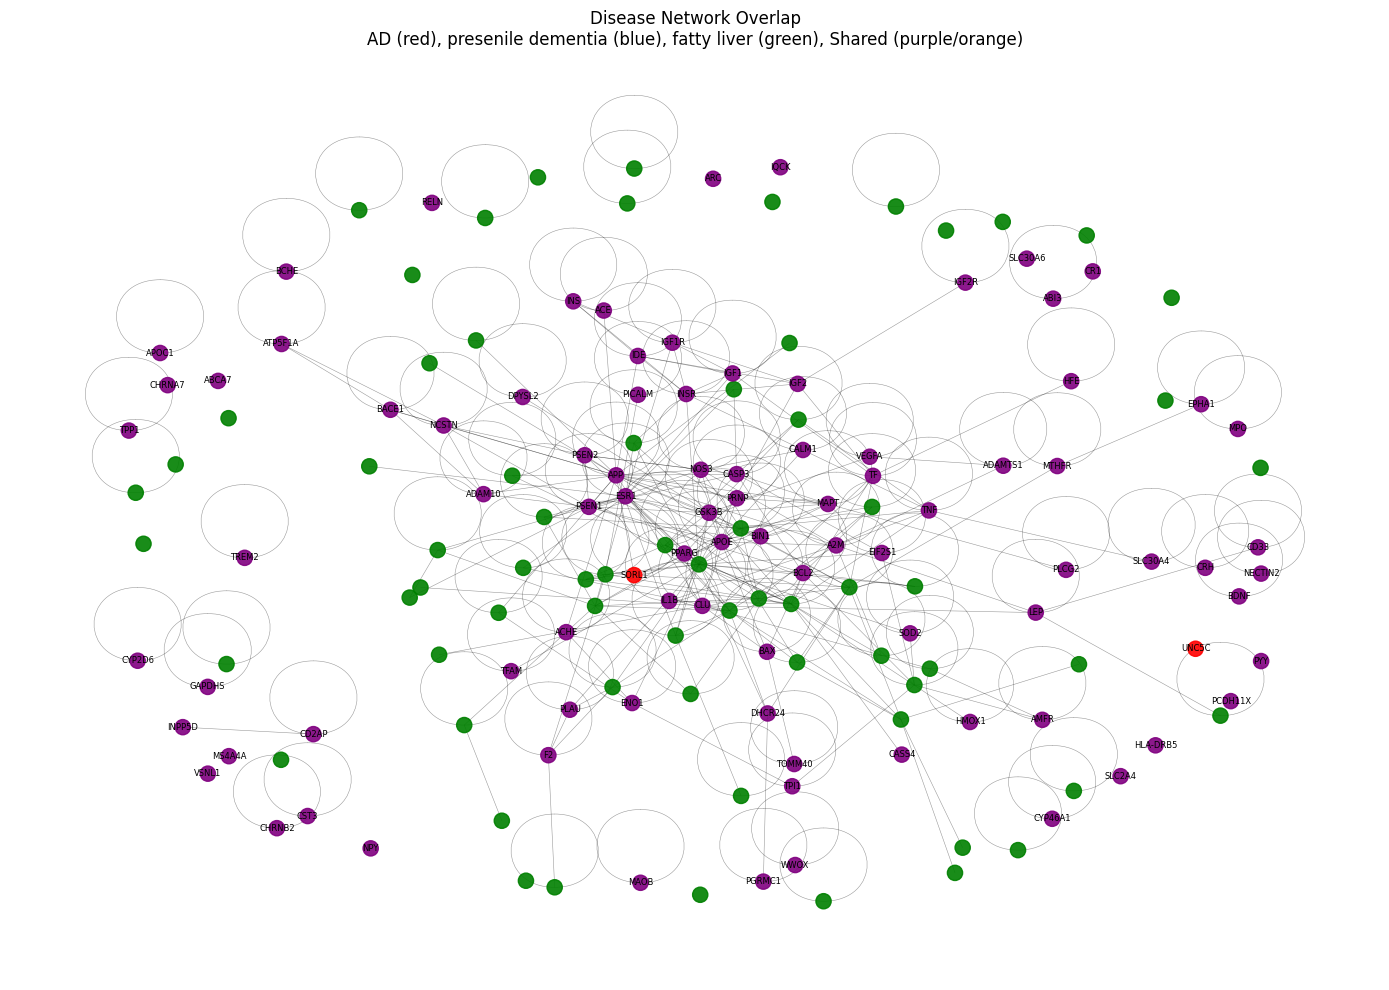


Overlap Statistics:
  AD ∩ presenile dementia: 89 genes
  AD ∩ fatty liver: 6 genes


In [20]:
# Visualize disease overlap
all_genes = genes_AD | genes_close | genes_far
H_vis = G.subgraph(all_genes).copy()

# Color mapping with legend info
colors = []
for n in H_vis.nodes():
    if n in genes_AD and n in genes_close:
        colors.append("purple")  # AD & Close overlap
    elif n in genes_AD and n in genes_far:
        colors.append("orange")   # AD & Far overlap
    elif n in genes_AD:
        colors.append("red")      # AD only
    elif n in genes_close:
        colors.append("blue")     # Close only
    else:
        colors.append("green")    # Far only

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(H_vis, seed=42, k=0.35)
nx.draw_networkx_nodes(H_vis, pos, node_size=120, node_color=colors, alpha=0.9)
nx.draw_networkx_edges(H_vis, pos, width=0.4, alpha=0.4)
nx.draw_networkx_labels(H_vis, pos, {n: n for n in genes_AD if n in genes_AD}, font_size=6)

# Dynamic title with selected diseases
plt.title(f"Disease Network Overlap\nAD (red), {close_disease} (blue), {far_disease} (green), Shared (purple/orange)")
plt.axis("off")
plt.tight_layout()
plt.savefig("../../images/Network_overlap.png", dpi=150, bbox_inches="tight")
plt.show()

# Summary statistics
print(f"\nOverlap Statistics:")
print(f"  AD ∩ {close_disease}: {len(genes_AD & genes_close)} genes")
print(f"  AD ∩ {far_disease}: {len(genes_AD & genes_far)} genes")

## 3.3 Drug-Disease Proximity

Following the approach from `proximity.py`, we compute drug-disease proximity with **degree-preserving randomization** to obtain statistical significance.

In [31]:
print(f"Drugs with valid targets: {len(drug_df)}")

Drugs with valid targets: 22007


In [32]:
print("Computing raw proximities for all drugs (fast)...")
drug_df["proximity"] = drug_df["targets_in_ppi"].apply(
    lambda tgts: calculate_closest_distance(G, set(tgts), genes_AD)
)
drug_df = drug_df.sort_values("proximity")

print(f"Raw proximity distribution:")
print(f"  Min: {drug_df['proximity'].min():.3f}")
print(f"  Max: {drug_df['proximity'].max():.3f}")
print(f"  Mean: {drug_df['proximity'].mean():.3f}")

Computing raw proximities for all drugs (fast)...
Raw proximity distribution:
  Min: 0.000
  Max: 4.000
  Mean: 1.507


In [33]:
# Identify repurposing candidates (exclude AD drugs)
drug_df["AD_indicated"] = drug_df["Indication"].str.contains(
    "alzheimer|dementia", case=False, na=False
)

# Separate AD drugs (positive controls) and repurposing candidates
ad_drugs = drug_df[drug_df["AD_indicated"]].sort_values("proximity")
repurposing = drug_df[~drug_df["AD_indicated"]].sort_values("proximity")

print(f"\nAD drugs found: {len(ad_drugs)}")
print(f"Repurposing candidates: {len(repurposing)}")


AD drugs found: 335
Repurposing candidates: 21672


In [34]:
# Step 3: SIGNIFICANCE ANALYSIS - Only for top candidates (slow but targeted)
print("\n" + "=" * 60)
print("SIGNIFICANCE ANALYSIS")
print("=" * 60)

# Test top 3 AD drugs (positive controls)
if len(ad_drugs) > 0:
    print("\nPOSITIVE CONTROLS (AD drugs):")
    for idx, row in ad_drugs.iloc[1:4].iterrows():
        drug_name = row["Name"]
        targets = row["targets_in_ppi"]
        
        result = get_proximity(G, targets, genes_AD, sims=1000)
        if result:
            print(f"{drug_name}: z={result['z_score']:.2f}, p={result['p_value']:.3f}")



SIGNIFICANCE ANALYSIS

POSITIVE CONTROLS (AD drugs):
Selegiline: z=-4.91, p=0.000
Flortaucipir F-18: z=-5.15, p=0.000
Flortaucipir F-18: z=-2.01, p=0.044


In [35]:
# Test top 5 repurposing candidates
print("\nREPURPOSING CANDIDATES:")
for idx, row in repurposing.head(10).iterrows():
    drug_name = row["Name"]
    targets = row["targets_in_ppi"]
    
    result = get_proximity(G, targets, genes_AD, sims=1000)
    if result and result['p_value'] < 0.05 and result['z_score'] < -1.5:
        print(f"✓ {drug_name}: z={result['z_score']:.2f}, p={result['p_value']:.3f}")
    elif result:
        print(f"- {drug_name}: z={result['z_score']:.2f}, p={result['p_value']:.3f}")


REPURPOSING CANDIDATES:
✓ Lepirudin: z=-3.12, p=0.002
✓ Moxisylyte: z=-3.86, p=0.000
✓ Isosorbide: z=-2.14, p=0.032
✓ Arotinolol: z=-5.31, p=0.000
✓ Tafenoquine: z=-5.16, p=0.000
✓ CRA_8696: z=-3.62, p=0.000
✓ Butyrfentanyl: z=-6.04, p=0.000
✓ CRA_8696: z=-3.12, p=0.002
✓ Dasabuvir: z=-6.00, p=0.000
✓ 5-[4-(1-Carboxymethyl-2-Oxo-Propylcarbamoyl)-Benzylsulfamoyl]-2-Hydroxy-Benzoic Acid: z=-2.30, p=0.022


Creating distribution plots for Simvastatin, YSIL6, and ATL1101
Found 3 matching drugs: ['YSIL6', 'ATL1101', 'Simvastatin']


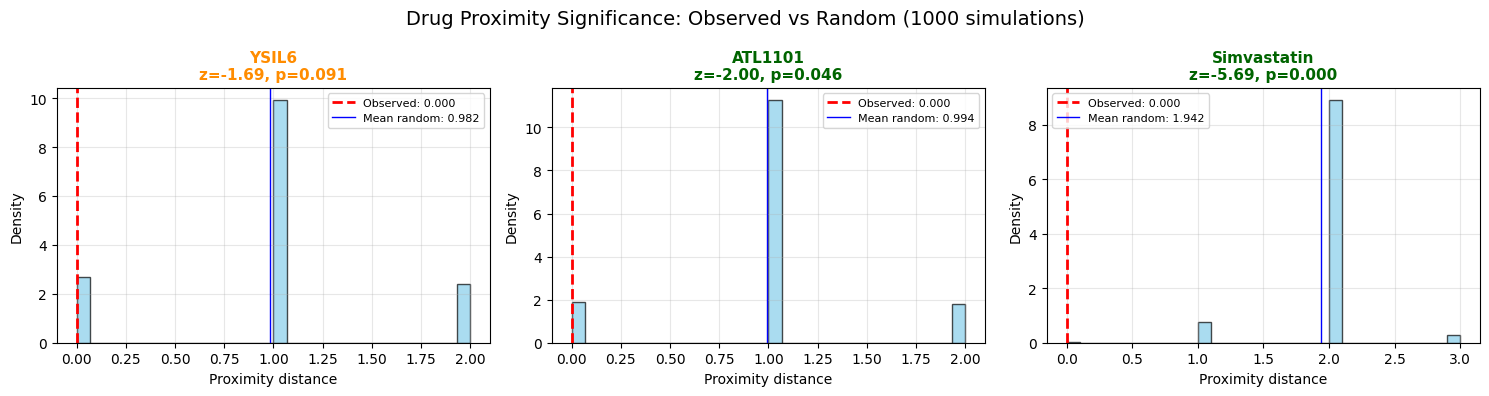

In [36]:
# Plot distributions for the three specific examples
print("Creating distribution plots for Simvastatin, YSIL6, and ATL1101")

# Find these specific drugs in your repurposing dataframe (exact matches only)
selected_drugs = ['Simvastatin', 'YSIL6', 'ATL1101']
selected_rows = repurposing[repurposing['Name'].isin(selected_drugs)].head(3)  # Limit to first 3 matches

print(f"Found {len(selected_rows)} matching drugs: {list(selected_rows['Name'])}")

# Create 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Drug Proximity Significance: Observed vs Random (1000 simulations)', fontsize=14)

for plot_idx in range(len(selected_rows)):  # Use range() instead of enumerate to control indexing
    row = selected_rows.iloc[plot_idx]  # Use iloc for positional indexing
    drug_name = row["Name"]
    targets = row["targets_in_ppi"]
    
    # Get proximity results with random distribution
    result = get_proximity(G, targets, genes_AD, sims=1000)
    
    if result and 'proximity_list' in result:
        random_proximities = [p for p in result['proximity_list'] if not np.isnan(p)]
        observed_proximity = result['proximity']
        z_score = result['z_score']
        p_value = result['p_value']
        
        # Plot histogram
        ax = axes[plot_idx]  # Now plot_idx will be 0, 1, 2
        ax.hist(random_proximities, bins=30, alpha=0.7, color='skyblue', edgecolor='black', density=True)
        ax.axvline(observed_proximity, color='red', linestyle='--', linewidth=2, 
                  label=f'Observed: {observed_proximity:.3f}')
        ax.axvline(np.mean(random_proximities), color='blue', linestyle='-', linewidth=1,
                  label=f'Mean random: {np.mean(random_proximities):.3f}')
        
        # Color code based on significance
        is_significant = p_value < 0.05 and z_score < -1.5
        title_color = 'darkgreen' if is_significant else 'darkorange'
        
        ax.set_title(f'{drug_name}\nz={z_score:.2f}, p={p_value:.3f}', 
                    fontsize=11, color=title_color, fontweight='bold')
        ax.set_xlabel('Proximity distance')
        ax.set_ylabel('Density')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../../images/three_examples_proximity.png", dpi=150, bbox_inches="tight")
plt.show()